In [1]:
!pip install --quiet pdetransformer

## Initialize PDE-S with pretrained weights from huggingface

In [2]:
from pdetransformer.core.separate_channels import PDETransformer, Supervised
import torch

# Load pre-trained model
model = PDETransformer.from_pretrained('thuerey-group/pde-transformer', subfolder='sc-s').cuda()
strategy = Supervised(model, timesteps=2)

/home/holzschuh/anaconda3/envs/diffusion/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/holzschuh/anaconda3/envs/diffusion/lib/python3.12/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/home/holzschuh/anaconda3/envs/diffusion/lib/python3.12/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/home/holzschuh/anaconda3/envs/diffusion/lib/python3.12/site-packages/lightnin

## Load dataset 

In [3]:
from pdetransformer.data import MultiDataModule

dataset = 'kolm_flow'
dataset_name = 'Kolmogorov Flow'
field = 'Vorticity'

params_data = {
    'path_index':
        {'2D_APE_xxl': './datasets'},
    'dataset_names': [ dataset ],
    'dataset_type': '2D_APE_xxl',
    'unrolling_steps': 1,
    'test_unrolling_steps': 29,
    'batch_size': 1,
    'num_workers': 1,
    'cache_strategy': 'none',
    'different_resolution_strategy': 'none',
    'normalize_data': 'mean-std',
    'normalize_const': 'mean-std',
    'downsample_factor': 1,
    'max_channels': 2,
}

data_module = MultiDataModule(**params_data)
data_module.setup(stage='test')
test_loader = data_module.test_dataloader()

dict_keys(['diff', 'kdv', 'hyp', 'kolm_flow', 'ks_test', 'gs_alpha_test', 'ks', 'fisher', 'kolm_flow_test', 'gs_alpha', 'burgers'])
Success: Loaded kolm_flow with 60 simulations and 29 samples each.
dict_keys(['diff', 'kdv', 'hyp', 'kolm_flow', 'ks_test', 'gs_alpha_test', 'ks', 'fisher', 'kolm_flow_test', 'gs_alpha', 'burgers'])
Success: Loaded kolm_flow_test with 5 simulations and 1 samples each.


In [4]:
data = next(iter(test_loader))
prediction, reference = strategy.predict(data, device=torch.device('cuda'), num_frames=29)

100%|███████████████████████████████████████████| 28/28 [00:00<00:00, 29.94it/s]


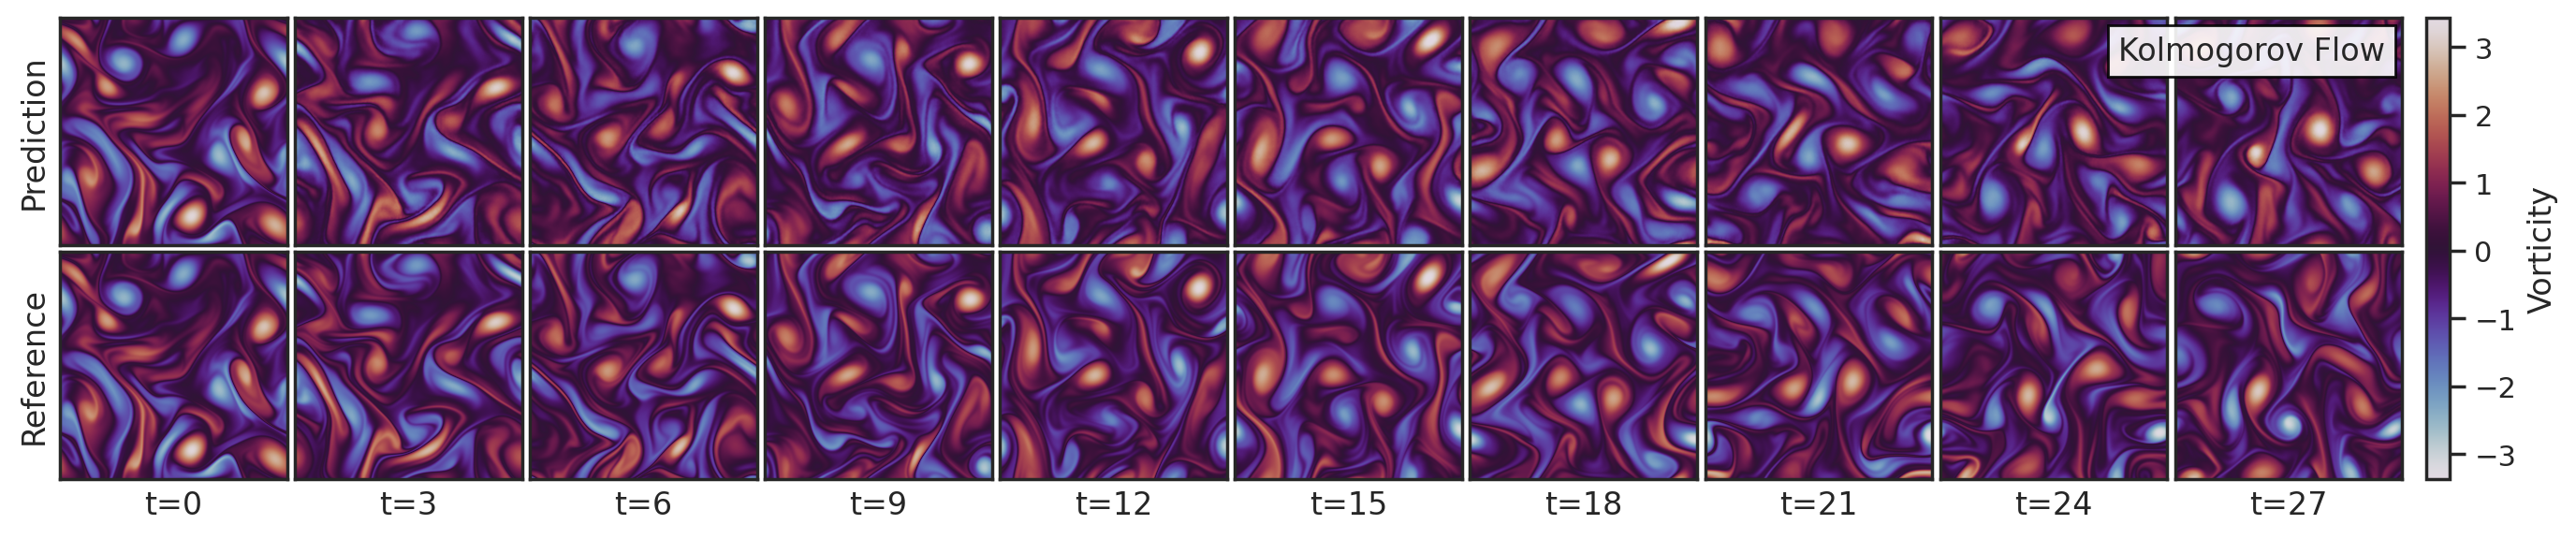

In [5]:
from matplotlib import pyplot as plt
import seaborn as sns

time_steps = [0, 3, 6, 9, 12, 15, 18, 21, 24, 27]

prediction_steps = prediction[0, :, :, :]
reference_steps = reference[0, :, :, :]

sns.set_theme(style="white")
cmap = sns.color_palette("twilight", as_cmap=True)

fig, axes = plt.subplots(2, len(time_steps), figsize=(16.65,3.2), dpi=200)

vmin = reference_steps.min()
vmax = reference_steps.max()

for j, t in enumerate(time_steps):

    axes[0, j].imshow(prediction_steps[t][0],  cmap=cmap, vmin=vmin, vmax=vmax)

    axes[0, j].set_xticks([])
    axes[0, j].set_yticks([])

    axes[1, j].imshow(reference_steps[t][0], cmap=cmap,
                        vmin=vmin, vmax=vmax)

    axes[1, j].set_xticks([])
    axes[1, j].set_yticks([])

axes[0, 0].set_ylabel('Prediction', fontsize=12)
axes[1, 0].set_ylabel('Reference', fontsize=12)

for j, t in enumerate(time_steps):
    axes[1, j].set_xlabel(f't={t}', fontsize=12)

fig.text(0.8712, 0.85, f'{dataset_name}',
            fontsize=12, ha='right', va='top', bbox=dict(facecolor='white', alpha=0.9, edgecolor='black'))

plt.subplots_adjust(wspace=0.03, hspace=0.03)

cbar = fig.colorbar(axes[0, 0].images[0], ax=axes, orientation='vertical', fraction=0.02, pad=0.01)
cbar.set_label(field, fontsize=12)

## Model input for single step

In [6]:
from pdetransformer.core.separate_channels.train_supervised import get_model_input, preprocess_batch_autoregressive

In [7]:
patch_size = 4
timesteps = 2
num_frames = 29
device = torch.device('cuda')

# processing of batch
data = preprocess_batch_autoregressive(data, patch_size=patch_size, timesteps=timesteps, num_frames=num_frames, device=device)
data = get_model_input(data, patch_size=patch_size)

In [8]:
channel_inputs, _, _, channel_pdes, channel_constants, \
            channel_constants_class, channel_idx, channel_time_step_strides, channel_task_embs, simulation_time, t_in = data

In [9]:
print("Channel inputs shapes:")
for i, channel in enumerate(channel_inputs):
    print(f"Channel {i}: {channel.shape}")

Channel inputs shapes:
Channel 0: torch.Size([1, 2, 256, 256])
Channel 1: torch.Size([1, 2, 256, 256])


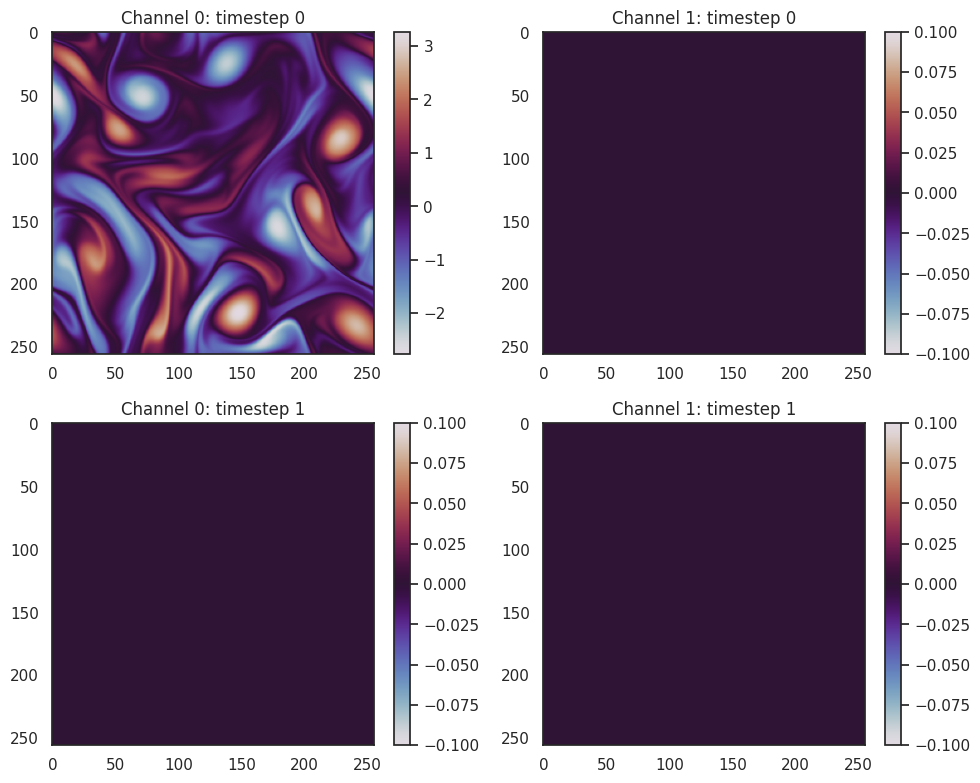

In [10]:
from matplotlib import pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(10, 8))

for i, channel in enumerate(channel_inputs):
    im = axes[0, i].imshow(channel[0,0].cpu(), cmap='twilight')
    axes[0, i].set_title(f'Channel {i}: timestep 0')
    plt.colorbar(im, ax=axes[0,i])
    
for i, channel in enumerate(channel_inputs):
    im = axes[1, i].imshow(channel[0,1].cpu(), cmap='twilight')
    axes[1,i].set_title(f'Channel {i}: timestep 1') 
    plt.colorbar(im, ax=axes[1,i])

plt.tight_layout()
plt.show()


In [11]:
print('Simulation time: ', [elem.cpu().numpy() for elem in simulation_time])
print('Channel type: ', [elem.cpu().numpy() for elem in channel_idx])
print('PDE type: ', [elem.cpu().numpy() for elem in channel_pdes])
print('Parameters: ', [elem.cpu().numpy() for elem in channel_constants])
print('Parameter types: ', [elem.cpu().numpy() for elem in channel_constants_class])
print('Delta t: ', [elem.cpu().numpy() for elem in channel_time_step_strides])
print('Task: ', [elem.cpu().numpy() for elem in channel_task_embs])
print('Time t: ', [elem.cpu().numpy() for elem in t_in])

Simulation time:  [array([0.], dtype=float32), array([0.], dtype=float32)]
Channel type:  [array([4]), array([0])]
PDE type:  [array([[16]]), array([[16]])]
Parameters:  [array([[0.00079613, 0.        , 0.        , 0.        , 0.        ]],
      dtype=float32), array([[0.00079613, 0.        , 0.        , 0.        , 0.        ]],
      dtype=float32)]
Parameter types:  [array([[7, 0, 0, 0, 0]]), array([[7, 0, 0, 0, 0]])]
Delta t:  [array([1]), array([1])]
Task:  [array([0]), array([0])]
Time t:  [array([0.], dtype=float32), array([0.], dtype=float32)]


The different variables have the following meaning: 
- **Simulation time**: physical time within the simulation trajectory. Can be set to 0 always
- **Channel type**: type of channel. 4 represents vorticity. 0 represents masked/unused
- **PDE type**: type of PDE. 16 represents Kolmogorov flow.            
- **Parameters/Types**: up to 5 simulation specific parameters. The type 7 represents viscosity
- **Delta t**: physical time spacing between timesteps
- **Task**: type of task. 0 represents autoregressive prediction
- **Time t**: time for denoising when training a probabilistic model

In [12]:
with torch.no_grad():
    prediction = model.forward(x=channel_inputs,
                           simulation_time=simulation_time,
                           channel_type=channel_idx,
                           pde_type=channel_pdes,
                           pde_parameters=channel_constants,
                           pde_parameters_class=channel_constants_class,
                           simulation_dt=channel_time_step_strides,
                           task=channel_task_embs,
                           t=t_in)

Output shapes:
Channel 0: torch.Size([1, 2, 256, 256])
Channel 1: torch.Size([1, 2, 256, 256])


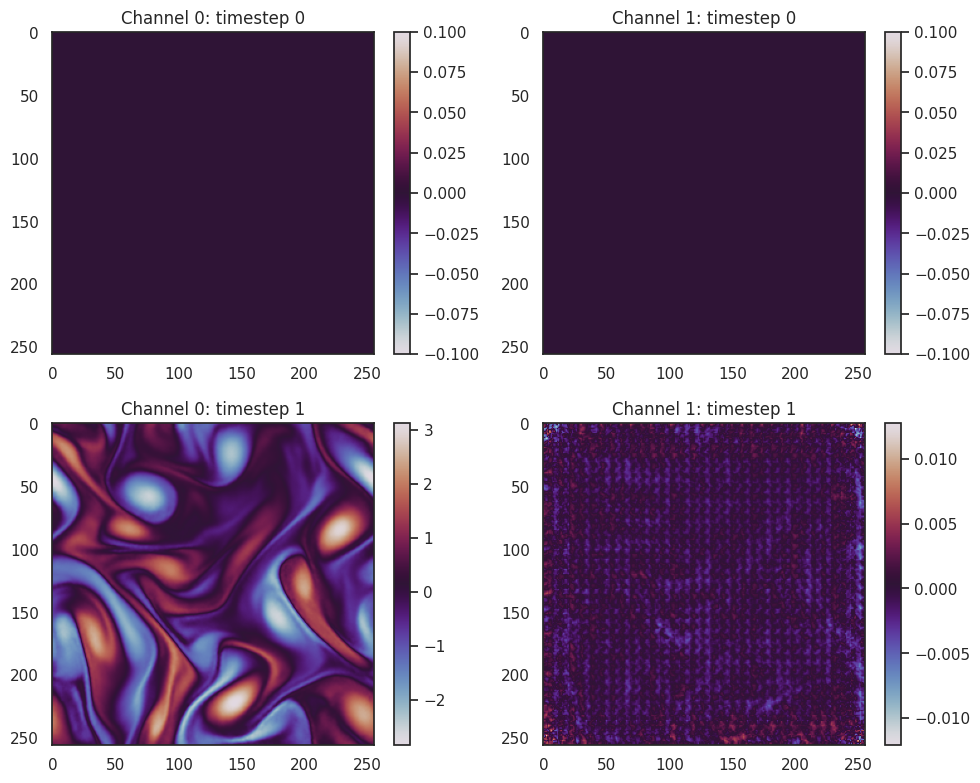

In [13]:
channel_outputs = prediction.sample

print("Output shapes:")
for i, channel in enumerate(channel_outputs):
    print(f"Channel {i}: {channel.shape}")

fig, axes = plt.subplots(2, 2, figsize=(10, 8))

for i, channel in enumerate(channel_outputs):
    im = axes[0, i].imshow(channel[0,0].cpu(), cmap='twilight')
    axes[0, i].set_title(f'Channel {i}: timestep 0')
    plt.colorbar(im, ax=axes[0,i])
    
for i, channel in enumerate(channel_outputs):
    im = axes[1, i].imshow(channel[0,1].cpu(), cmap='twilight')
    axes[1,i].set_title(f'Channel {i}: timestep 1') 
    plt.colorbar(im, ax=axes[1,i])
    
plt.tight_layout()
plt.show()